# Comparative analysis of brain organisation in two brain regions

In this tutorial, we use `siibra` to analyze multimodal aspects of two different brain regions. We select a region from the Broca region in the inferior frontal gyrus, IFG 44, involved in language prociessing, and a region from the visual system in the occipital cortex, V1.

### Load packages

We start by importing the siibra package and libraries for visualization.

In [4]:
import siibra
assert siibra.__version__ >= "2.0.0.a01"
import matplotlib.pyplot as plt
from nilearn import plotting
import pandas as pd
import numpy as np
plt.style.use('seaborn')

C:\Users\INM-1\AppData\Local\Temp\ipykernel_10544\844740193.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Instantiate parcellation and reference space from the human brain atlas

In [11]:
jubrain = siibra.parcellations['julich 3.0.3']
pmaps = jubrain.get_map(space='mni 152', maptype='statistical', name='157')

### Instantiate the two regions of interest

AttributeError: 'Region' object has no attribute 'key'

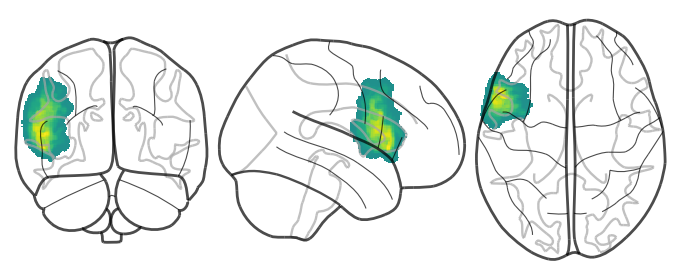

In [14]:
specs = ['ifg 44 left', 'hoc1 left']
regions = [jubrain.get_region(spec) for spec in specs]
for r in regions:
    plotting.plot_glass_brain(
        pmaps.extract_regional_map(region=r).get_data(), cmap='viridis', draw_cross=False, colorbar=False, annotate=False
    )
    plt.savefig(f"{r.name}.png")

### Compare average receptor and cortical cell densities

AttributeError: 'Region' object has no attribute 'key'

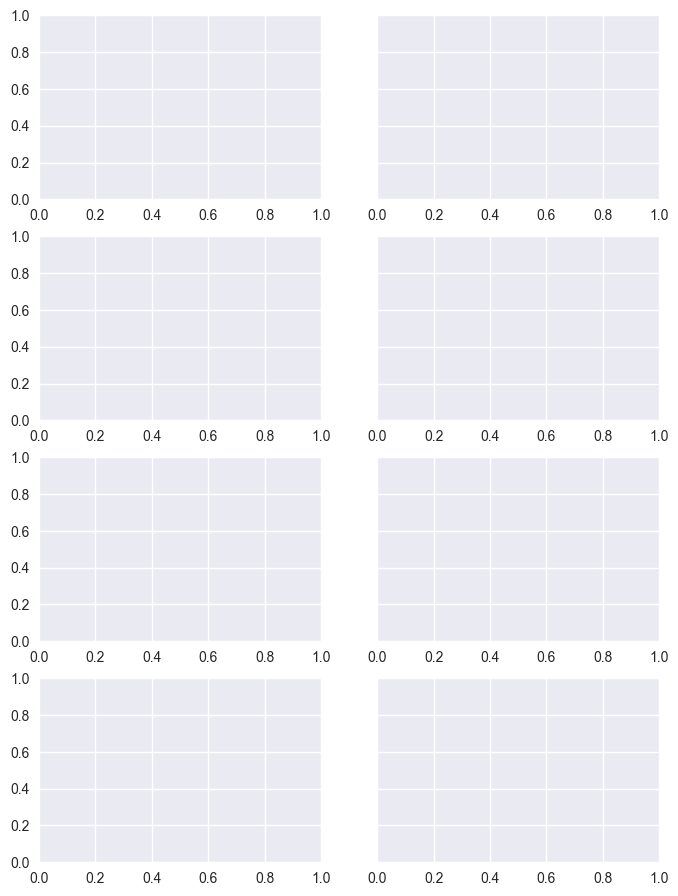

In [16]:
genes=[
    siibra.vocabularies.GENE_NAMES.GABRA1,
    siibra.vocabularies.GENE_NAMES.GABRA2,
    siibra.vocabularies.GENE_NAMES.GABRA3,
    siibra.vocabularies.GENE_NAMES.GABRA4,
    siibra.vocabularies.GENE_NAMES.GABRA5,
    siibra.vocabularies.GENE_NAMES.GABRA6,
    siibra.vocabularies.GENE_NAMES.GABRB1,
    siibra.vocabularies.GENE_NAMES.GABRB2,
    siibra.vocabularies.GENE_NAMES.GABRB3,
    siibra.vocabularies.GENE_NAMES.GABRD,
    siibra.vocabularies.GENE_NAMES.GABRE,
    siibra.vocabularies.GENE_NAMES.GABRG1,
    siibra.vocabularies.GENE_NAMES.GABRG2,
    siibra.vocabularies.GENE_NAMES.GABRG3,
    siibra.vocabularies.GENE_NAMES.GABRP,
    siibra.vocabularies.GENE_NAMES.GABRQ,
    siibra.vocabularies.GENE_NAMES.GABRR1,
    siibra.vocabularies.GENE_NAMES.GABRR2,
    siibra.vocabularies.GENE_NAMES.GABRR3
]
modalities = [
    (siibra.modality_vocab.modality.NEUROTRANSMITTER_RECEPTOR_DENSITY, {}, {"rot":90}),
    (siibra.modality_vocab.modality.LAYERWISE_MODIFIED_SILVER_STAINING, {}, {"rot":0}),
    (siibra.modality_vocab.modality.GENE_EXPRESSIONS, {'gene': genes}, {"rot":90})
]
f, axs = plt.subplots(len(modalities)+1, len(regions), figsize=(4*len(regions),11), sharey='row')
ymax = [4500, 150, None]

for i, region in enumerate(regions): 
    axs[0, i].imshow(plt.imread(f"{region.name}.png"))
    axs[0, i].set_title(f'{region.name.replace("Area ", "")}')
    axs[0, i].axis('off')
    for j, (modality, kwargs, plotargs) in enumerate(modalities):
        fts = siibra.find_features(region, modality, **kwargs)
        assert len(fts) > 0
        if len(fts) > 1:
            print(f"More than one feature found for {modality}, {region.name}")
        fts[0].plot(ax = axs[j+1, i], **plotargs)
        if ymax[j] is not None:
            axs[j+1, i].set_ylim(0, ymax[j])
        if 'std' in axs[j+1, i].yaxis.get_label_text():
            axs[j+1, i].set_ylabel(axs[j+1, i].yaxis.get_label_text().replace('std', 'std\n'))
        axs[j+1, i].set_title(f'{fts[0].modality}')
f.suptitle('')
f.tight_layout()

In [ ]:
fts = siibra.features.get(regions[0], siibra.features.connectivity.StreamlineCounts)
conn = fts[0]

In [ ]:
N = 20

# aggregate connectivity profiles for first region across subjects
D1 = (
    pd.concat([c.get_profile(regions[0]).data for c in conn], axis=1)
    .agg(['mean', 'std'], axis=1)
    .sort_values(by='mean', ascending=False)
)

# aggregate connectivity profiles for second region across subjects
D2 = (
    pd.concat([c.get_profile(regions[1]).data for c in conn], axis=1)
    .agg(['mean', 'std'], axis=1)
    .sort_values(by='mean', ascending=False)
)

# choose target regions as the one with strongest connectivity in any of the two
targets = (
    pd.concat([D1['mean'], D2['mean']], axis=1)
    .agg(['max'], axis=1)
    .sort_values(by='max', ascending=False)[:N]
    .index
)

# plot both average connectivity profiles to target regions
def shorten_name(n):
    return n.replace('Area ', '').replace(' (GapMap)', '').replace('left', 'L').replace('right', 'R')

fig, (a1, a2) = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(6, 5.5))
kwargs = {'kind':'bar', 'logy':True}
D1.loc[targets]['mean'].plot(**kwargs, yerr=D1.loc[targets]['std'], ax=a1, ylabel=shorten_name(regions[0].name))
D2.loc[targets]['mean'].plot(**kwargs, yerr=D2.loc[targets]['std'], ax=a2, ylabel=shorten_name(regions[1].name))
a2.xaxis.set_ticklabels([shorten_name(t.get_text()) for t in a2.xaxis.get_majorticklabels()])
fig.suptitle(conn.modality)
plt.tight_layout()

In [ ]:
a1.set_title('')

In [ ]:
fig, (a1, a2) = plt.subplots(1, 2, sharey=True, figsize=(3*len(regions), 3.5))
kwargs = {'kind':'bar', 'width': 0.85, 'logy':True}
D1.iloc[:15]['mean'].plot(**kwargs, yerr=D1.iloc[:15]['std'], ax=a1, ylabel=shorten_name(regions[0].name))
D2.iloc[:15]['mean'].plot(**kwargs, yerr=D2.iloc[:15]['std'], ax=a2, ylabel=shorten_name(regions[1].name))
a1.set_ylabel('Streamline counts')
a1.xaxis.set_ticklabels([shorten_name(t.get_text()) for t in a1.xaxis.get_majorticklabels()])
a2.xaxis.set_ticklabels([shorten_name(t.get_text()) for t in a2.xaxis.get_majorticklabels()])
plt.tight_layout()

### Retrieve cortical patches

In [ ]:
layers = siibra.parcellations.get('cortical layers')
layermap = layers.get_map(space='bigbrain')
patches = {}
import numpy as np

for r in regions:
    # find 1 micron sections intersecting the region
    pmap_volume = siibra.volumes.from_nifti(pmaps.fetch(region=r), space='mni152', name=r.name)
    sections = siibra.features.get(pmap_volume, siibra.features.cellular.CellbodyStainedSection)
    section = sections[len(sections)//2]

    # intersect layer IV surface with the selected section
    imgplane = siibra.experimental.Plane3D.from_image(section)
    hemisphere = 'left' if 'left' in r.name else 'right'
    l4layer = layers.get_region(f"4 {hemisphere}")
    l4_contours = imgplane.intersect_mesh(layermap.fetch(region=l4layer, format='mesh'))
    
    # score all contour points with the region probabilities to find the most likely one
    l4points = siibra.PointSet(
        [p for contour in l4_contours for p in contour], 
        space='bigbrain'
    )
    probs = pmap_volume.evaluate_points(l4points)
    l4point = l4points[probs.argmax()]
    
    # find the closest cortical profile to this point
    profile = siibra.experimental.CorticalProfileSampler().query(l4point)
    
    # extract the patch in the image plane showing the projection of this profile
    patch_canvas = imgplane.get_enclosing_patch(profile)
    i = np.argmin(
        np.linalg.norm((patch_canvas.corners.coordinates - profile[0].coordinate), axis=1)
    )
    if i in [0, 3]:
        patch_canvas.flip()
    patches[r] = patch_canvas.extract_volume(section, resolution_mm=0.01)

In [ ]:
# display the two extracted patches
f, axs = plt.subplots(1, 2)
for ax, patch, region in zip(axs, patches, regions):
    
    # access the underlying image data
    patchimg = patches[patch].fetch()
    phys2vox = np.linalg.inv(patchimg.affine)
    patchdata = patchimg.get_fdata().squeeze()
    
    ax.set_title(region.name)

    # plot the pure image array
    ax.imshow(patchdata, cmap='gray', vmin=0, vmax=2**16)
    ax.axis('off')

plt.tight_layout()